<a href="https://colab.research.google.com/github/vnprr/LifeThread/blob/main/Life_Threat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!pip install datasets
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## 1st Dataset

In [4]:
!kaggle datasets download -d xavrig/reddit-dataset-rdepression-and-rsuicidewatch
!unzip -q -n reddit-dataset-rdepression-and-rsuicidewatch.zip

Dataset URL: https://www.kaggle.com/datasets/xavrig/reddit-dataset-rdepression-and-rsuicidewatch
License(s): unknown
 83% 5.00M/6.00M [00:00<00:00, 39.8MB/s]
100% 6.00M/6.00M [00:00<00:00, 46.4MB/s]


In [5]:
!ls

drive						  reddit_depression_suicidewatch.csv
reddit-dataset-rdepression-and-rsuicidewatch.zip  sample_data


##2nd Dataset

In [6]:
!kaggle datasets download -d nikhileswarkomati/suicide-watch
!unzip -q -n suicide-watch.zip

Dataset URL: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
License(s): CC-BY-SA-4.0
 81% 49.0M/60.6M [00:00<00:00, 52.7MB/s]
100% 60.6M/60.6M [00:01<00:00, 62.0MB/s]


In [7]:
!ls

drive						  sample_data
reddit-dataset-rdepression-and-rsuicidewatch.zip  Suicide_Detection.csv
reddit_depression_suicidewatch.csv		  suicide-watch.zip


## Processing data

In [8]:
import pandas as pd
from transformers import pipeline
import os

# Ścieżka do pliku
file_path = '/content/drive/MyDrive/Colab Notebooks/SW/combined_data.csv'

# CHECK IF FILE EXISTS
if os.path.exists(file_path):
    print(f"Plik {file_path} znaleziony. Ładowanie danych...")
    combined_data = pd.read_csv(file_path)

else:
    print(f"Plik {file_path} nie znaleziony. Przeprowadzanie analizy sentymentu...")

    # Wczytaj oba zbiory danych
    data1 = pd.read_csv('Suicide_Detection.csv')
    data2 = pd.read_csv('reddit_depression_suicidewatch.csv')

    # 1. Zmiana etykiet na liczbowe
    # Zakładamy, że kolumna etykiet nazywa się 'class'
    label_mapping = {'depression': 0, 'non-suicide': 0, 'SuicideWatch': 1, 'suicide': 1}

    # Zastosowanie mapowania do obu zbiorów
    data1['class'] = data1['class'].map(label_mapping)
    data2['class'] = data2['label'].map(label_mapping)
    del data1[data1.columns[0]]
    data2 = data2.drop(columns=['label'])

    # 2. Ujednolicenie tekstu na małe litery (zakładamy, że kolumna tekstu nazywa się 'text')
    data1['text'] = data1['text'].str.lower()
    data2['text'] = data2['text'].str.lower()

    # 3. Połączenie obu zbiorów danych
    combined_data = pd.concat([data1, data2], ignore_index=True)

    # Usunięcie duplikatów na podstawie tekstu
    combined_data.drop_duplicates(subset=['text'], inplace=True)

    # Zapisanie wyników do pliku CSV
    combined_data.to_csv(file_path, index=False)


Plik /content/drive/MyDrive/Colab Notebooks/SW/combined_data.csv znaleziony. Ładowanie danych...


In [9]:
# print(data2.info())
# print(data1.info())
# print(combined_data.info())

print(combined_data.head())

                                                text  class
0  ex wife threatening suiciderecently i left my ...      1
1  am i weird i don't get affected by compliments...      0
2  finally 2020 is almost over... so i can never ...      0
3          i need helpjust help me im crying so hard      1
4  i’m so losthello, my name is adam (16) and i’v...      1


In [10]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from tqdm import tqdm
import torch

# Ścieżka do pliku z zapisanymi wynikami analizy sentymentu
file_path = '/content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv'

# CHECK IF FILE EXISTS
if os.path.exists(file_path):
    print(f"Plik {file_path} znaleziony. Ładowanie danych...")
    combined_data = pd.read_csv(file_path)

else:
    # Sprawdzenie, czy GPU jest dostępne
    device = 0 if torch.cuda.is_available() else -1

    # Załaduj model i tokenizer bezpośrednio
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Utwórz pipeline z modelu i tokenizer
    sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

    # Włączenie wsparcia tqdm dla pandas
    tqdm.pandas()

    # Funkcja do analizy sentymentu z uwzględnieniem maksymalnej długości sekwencji
    def analyze_sentiment(post):
        # Tokenizacja z maksymalną długością sekwencji i obcięciem
        tokens = tokenizer(post, truncation=True, padding='max_length', max_length=512, return_tensors='pt') # Changed max_length to 512
        # Przeprowadzenie analizy sentymentu
        results = sentiment_analysis(post, truncation=True) # Added truncation to the pipeline call
        return results[0]['score']

    # Analiza sentymentu z wskaźnikiem postępu
    combined_data['sentiment'] = combined_data['text'].progress_apply(analyze_sentiment)

    # Zapisz plik CSV w folderze na Google Drive
    combined_data.to_csv('/content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv', index=False)


print(combined_data.head())

Plik /content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv znaleziony. Ładowanie danych...
                                                text  class  sentiment
0  ex wife threatening suiciderecently i left my ...      1   0.993805
1  am i weird i don't get affected by compliments...      0   0.999523
2  finally 2020 is almost over... so i can never ...      0   0.999436
3          i need helpjust help me im crying so hard      1   0.998133
4  i’m so losthello, my name is adam (16) and i’v...      1   0.996261


In [11]:
from sklearn.preprocessing import QuantileTransformer

# Inicjalizacja transformatora kwantylowego
quantile_transformer = QuantileTransformer(output_distribution='uniform')

# Zastosowanie transformacji
combined_data['sentiment'] = quantile_transformer.fit_transform(combined_data[['sentiment']])

# Wyświetlenie znormalizowanych wartości
print(combined_data.head())

                                                text  class  sentiment
0  ex wife threatening suiciderecently i left my ...      1   0.335118
1  am i weird i don't get affected by compliments...      0   0.899345
2  finally 2020 is almost over... so i can never ...      0   0.865603
3          i need helpjust help me im crying so hard      1   0.576798
4  i’m so losthello, my name is adam (16) and i’v...      1   0.426593


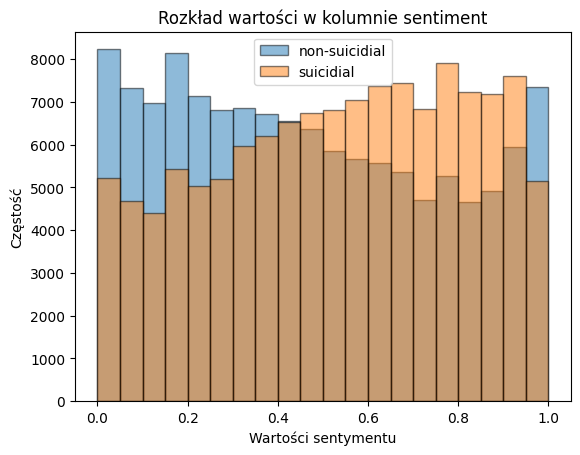

min: 0.0
max: 1.0
accuracy score: 0.561339910065173


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Rysowanie histogramu
combined_data['sentiment'][combined_data['class'] == 0].plot(kind='hist', bins=20, edgecolor='black', alpha=0.5, label='non-suicidial')
combined_data['sentiment'][combined_data['class'] == 1].plot(kind='hist', bins=20, edgecolor='black', alpha=0.5, label='suicidial')
plt.title('Rozkład wartości w kolumnie sentiment')
plt.xlabel('Wartości sentymentu')
plt.ylabel('Częstość')
plt.legend()
plt.show()

# min
print("min:", combined_data['sentiment'].min())

# max
print("max:", combined_data['sentiment'].max())

#accuracy
print("accuracy score:", accuracy_score(y_true=combined_data['class'], y_pred=combined_data['sentiment'] > 0.5))


#### Sentiment analysis reveals a noticeable trend, but a significant portion of suicidal posts remain difficult to identify based solely on sentiment.

In [13]:
combined_data = combined_data.drop(columns=['sentiment'])


##Train - preparations

In [14]:
combined_data.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,1
1,am i weird i don't get affected by compliments...,0
2,finally 2020 is almost over... so i can never ...,0
3,i need helpjust help me im crying so hard,1
4,"i’m so losthello, my name is adam (16) and i’v...",1


In [40]:
from sklearn.model_selection import train_test_split

# train / test split
train_data, test_data = train_test_split(combined_data,
                                         #test_size=0.05,   #małe liczby najlepsze dla eksperymentowania
                                         #train_size=0.05,
                                         random_state=42
                                         )

# Podział danych na cechy i etykiety
X_train = train_data['text']
X_test = test_data['text']
y_train = train_data['class']
y_test = test_data['class']

print(f"train size: {len(train_data)}")
print(f"test size: {len(test_data)}")

train size: 189303
test size: 63102


#Train

## Simple Models

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Zamiana tekstu na cechy numeryczne przy użyciu TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model: **Stochastic Gradient Descent**

In [ ]:
#Siatka hiperparametrów

# from sklearn.model_selection import GridSearchCV

# # Definiuj model
# model_sgd = SGDClassifier(loss='log_loss', max_iter=1000)

# # Definiuj siatkę hiperparametrów
# param_grid = {
#     'alpha': [0.0001, 0.001, 0.01],
#     'penalty': ['l1', 'l2'],
# }

# # Utwórz obiekt GridSearchCV
# grid_search = GridSearchCV(model_sgd, param_grid, cv=5)

# # Dopasuj GridSearchCV do danych treningowych
# grid_search.fit(X_train_tfidf, y_train)

# # Wyświetl najlepsze parametry
# print(grid_search.best_params_)

# # Użyj najlepszego modelu do predykcji
# best_model = grid_search.best_estimator_

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Definiowanie modelu regresji logistycznej
model_sgd = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000, penalty='l2')

# Trenowanie modelu
model_sgd.fit(X_train_tfidf, y_train)

# Ocena modelu
accuracy = model_sgd.score(X_test_tfidf, y_test)
print(f"Dokładność modelu regresji logistycznej: {accuracy:.4f}")

Dokładność modelu regresji logistycznej: 0.8932


In [40]:
# save on disc

import pickle

filename = '/content/drive/MyDrive/Programowanie/Life Thread/Models/SDGclassifier1.sav'
pickle.dump(model_sgd, open(filename, 'wb'))

#### Podsumowanie
Najlepsze wartości:
`model = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=10000, penalty='l2')`

Wartość max_iter została zoptymalizowana do 1000

Model osiągnął satysfakcjonujący wynik accuracy: 0.8932

---



### Model: **Naive Bayes**

In [45]:
#Siatka hiperparametrów

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Definiuj model
model_nb = MultinomialNB()

# Definiuj siatkę hiperparametrów
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
}

# Utwórz obiekt GridSearchCV
grid_search = GridSearchCV(model_nb, param_grid, cv=5)

# Dopasuj GridSearchCV do danych treningowych
grid_search.fit(X_train_tfidf, y_train)

# Wyświetl najlepsze parametry
print(grid_search.best_params_)

# Użyj najlepszego modelu do predykcji
best_model = grid_search.best_estimator_

# Ocena modelu
accuracy = best_model.score(X_test_tfidf, y_test)
print(f"Dokładność Naive Bayes: {accuracy:.4f}")


{'alpha': 0.1, 'fit_prior': True}
Dokładność Naive Bayes: 0.8743


In [44]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB(alpha=0.5, fit_prior=False)
model_nb.fit(X_train_tfidf, y_train)
accuracy = model_nb.score(X_test_tfidf, y_test)
print(f"Dokładność Naive Bayes: {accuracy:.4f}")

Dokładność Naive Bayes: 0.8739


In [47]:
# save on disc

import pickle

filename = '/content/drive/MyDrive/Programowanie/Life Thread/Models/NaiveBayes1.sav'
pickle.dump(model_nb, open(filename, 'wb'))

#### Podsumowanie

Model osiągnął satysfakcjonujący wynik accuracy: 0.8739

---



### Model: **Support Vector Machine**

In [ ]:
#Siatka hiperparametrów

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy') # 5-fold cross validation
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

In [ ]:
from sklearn.svm import SVC

model_svc = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)
accuracy = model_svc.score(X_test_tfidf, y_test)
print(f"Dokładność SVM: {accuracy:.4f}")

## BERT Models

In [24]:
from transformers import BartTokenizer, BartForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification # Added BertTokenizer and BertForSequenceClassification to the import statement
import torch

# Convert pandas DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Załaduj tokenizer i model BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizacja danych
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# Tokenizacja
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# rename
if 'class' in train_dataset.column_names:
  train_dataset = train_dataset.rename_column("class", "labels")
#  test_dataset = test_dataset.rename_column("class", "labels")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/12620 [00:00<?, ? examples/s]

Map:   0%|          | 0/12621 [00:00<?, ? examples/s]

### Model: **BERT**

In [33]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, ignore_mismatched_sizes=True
)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,  # Increase batch size to better utilize VRAM
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,  # Adjust gradient accumulation for large batch sizes
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_steps=10_000,
    logging_dir='./logs',
    logging_steps=200,
    fp16=False,  # Use full precision to leverage high VRAM capacity
    report_to="none"  # Disable reporting for speed optimization
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [27]:
results = trainer.evaluate()

In [28]:
print(results)

{'eval_loss': 0.24574919044971466, 'eval_runtime': 94.1284, 'eval_samples_per_second': 134.083, 'eval_steps_per_second': 8.382, 'epoch': 3.0}


#### Summary

Trained on 5% dataset, model rejected for optimization reasons

```
Epoch	 Training Loss 	Validation Loss
1	     0.207500	      0.179009
2	     0.096700      	0.190772
3	     0.044100	      0.245749

TrainOutput(global_step=2367, training_loss=0.12685552427020313, metrics={
  'train_runtime': 1300.4625,
  'train_samples_per_second': 29.113,
  'train_steps_per_second': 1.82,
  'total_flos': 9961384555929600.0,
  'train_loss': 0.12685552427020313,
  'epoch': 3.0})
```



### Model: **DistilBERT**

In [31]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer # add DistilBertTokenizer to the import statement
import torch

#gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert pandas DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Załaduj tokenizer i model DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenizacja danych
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenizacja
train_dataset = train_dataset.map(tokenize_function, batched=True, device=device)
test_dataset = test_dataset.map(tokenize_function, batched=True, device=device)

# rename
if 'class' in train_dataset.column_names:
  train_dataset = train_dataset.rename_column("class", "labels")
  test_dataset = test_dataset.rename_column("class", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/12620 [00:00<?, ? examples/s]

Map:   0%|          | 0/12621 [00:00<?, ? examples/s]

In [32]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,  # Increased batch size for potential speedup
    per_device_eval_batch_size=64,  # Increased batch size for potential speedup
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",  # Save only at the end of each epoch
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,  # Adjust learning rate if needed
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    gradient_accumulation_steps=2  # Accumulate gradients over multiple steps
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.359900,0.198333,0.924491,0.924482
2,0.114800,0.170077,0.936217,0.936217


TrainOutput(global_step=591, training_loss=0.19230835490218678, metrics={'train_runtime': 863.1127, 'train_samples_per_second': 43.864, 'train_steps_per_second': 0.685, 'total_flos': 5005148190818304.0, 'train_loss': 0.19230835490218678, 'epoch': 2.992405063291139})

In [34]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.1700766235589981, 'eval_accuracy': 0.9362174154187465, 'eval_f1': 0.9362174154187465, 'eval_runtime': 74.8884, 'eval_samples_per_second': 168.531, 'eval_steps_per_second': 2.644, 'epoch': 2.992405063291139}


In [ ]:
model.save_pretrained('/content/drive/MyDrive/distilbert_model')
tokenizer.save_pretrained('/content/drive/MyDrive/distilbert_tokenizer')

#### Podsumowanie

Na **5% danych** model osiągnął satysfakcjonujące rezultaty przy mniejszej złożoności od BERT.

Wydajność na zbiorze testowym:

```
Loss:     0.1701
Accuracy: 0.9362
```




---

